In [1]:
%matplotlib inline
import matplotlib
matplotlib.rc('font', **{'size': 12})

import pickle
import re
import datetime
from elasticsearch import Elasticsearch, helpers
from elasticsearch.helpers import scan
import datetime as dt

import numpy as np
import pandas as pd

import requests
import json


In [2]:
# Get AGIS endpoints (RSEs) and site names
r = requests.get('http://atlas-agis-api.cern.ch/request/site/query/list/ddmendpoints?json')
j = r.json()

In [3]:
#Create RSE to site name dictionary
rse2site = {}
for i in j:
    for ep in i['ddmendpoints']:
        rse2site[ep]=i['name']

In [98]:
print(rse2site['NDGF-T1_DATADISK'])

NDGF-T1


In [4]:
data = pd.read_csv('transfers_2017-02-01_07.csv')

In [8]:
data.sort_values(by='STARTED', inplace=True)

In [9]:
# Calculate the average rate for every transfer (SIZE/(STARTED - ENDED))
data['AVG_RATE'] = data.SIZE / (data.ENDED - data.STARTED)

In [27]:
# routine to calculete link occupancy at site level

def insert_transfer(transfer):
    src_key = rse2site[transfer['src']]
    net_key = rse2site[transfer['src']] + rse2site[transfer['dst']]
    dst_key = rse2site[transfer['dst']]
    
    if src_key not in occupancy_src.keys():
        occupancy_src[src_key] = []
    if net_key not in occupancy_net.keys():
        occupancy_net[net_key] = []
    if dst_key not in occupancy_dst.keys():
        occupancy_dst[dst_key] = []
    total_bytes_src = 0
    total_bytes_net = 0
    total_bytes_dst = 0
    total_rate_src = 0
    total_rate_net = 0
    total_rate_dst = 0
    for t in occupancy_src[src_key][:]:
        if int(t['end']) <= int(transfer['start']):
            occupancy_src[src_key].remove(t)
        else:
            total_bytes_src += int(t['size'])
            total_rate_src += int(t['rate'])
    for t in occupancy_net[net_key][:]:
        if int(t['end']) <= int(transfer['start']):
            occupancy_net[net_key].remove(t)
        else:
            total_bytes_net += int(t['size'])
            total_rate_net += int(t['rate'])
    for t in occupancy_dst[dst_key][:]:
        if int(t['end']) < int(transfer['start']):
            occupancy_dst[dst_key].remove(t)
        else:
            total_bytes_dst += int(t['size'])
            total_rate_dst += int(t['rate'])
    occupancy_src[src_key].append(transfer)
    occupancy_net[net_key].append(transfer)
    occupancy_dst[dst_key].append(transfer)
    # consistency check
    if (len(occupancy_net[net_key]) > len(occupancy_dst[dst_key])):
        print(occupancy_net[net_key])
        print(occupancy_dst[dst_key])
        raise ValueError
    
    results = [ len(occupancy_src[src_key]),
                len(occupancy_net[net_key]), 
                len(occupancy_dst[dst_key]), 
                total_bytes_src,
                total_bytes_net,
                total_bytes_dst,
                total_rate_src,
                total_rate_net,
                total_rate_dst,
                ]
    return results

In [34]:
len(data)

21255208

In [ ]:
import time

stats = []
n = 0
occupancy_src = {}
occupancy_net = {}
occupancy_dst = {}

ts = time.time()
for d in data.iterrows():
    t = {'src': d[1][0],
         'dst': d[1][1],
         'act': d[1][2],
         'size': d[1][3],
         'subm': d[1][4],
         'start': d[1][5],
         'end': d[1][6],
         'rate': d[1][7],
        }
    stats.append(insert_transfer(t))
    n += 1
    #if n > 300000:
    #    break
    if (n % 100000) == 0:
        print(time.time() - ts,n)
        ts = time.time()
#print(stats)

In [46]:
data['OC_SRC'] = np.array(stats).T[0]
data['OC_NET'] = np.array(stats).T[1]
data['OC_DST'] = np.array(stats).T[2]
data['BYTES_SRC'] = np.array(stats).T[3]
data['BYTES_NET'] = np.array(stats).T[4]
data['BYTES_DST'] = np.array(stats).T[5]
data['RATE_SRC'] = np.array(stats).T[6]
data['RATE_NET'] = np.array(stats).T[7]
data['RATE_DST'] = np.array(stats).T[8]



In [47]:
data['TTC'] = data.ENDED - data.STARTED

In [48]:
data.to_csv('transfers_2017-02-01_07-plus_stats.csv', index=False)

In [ ]:
data.corr()

In [67]:
l = [rse2site[x]for x in data.DST.values]

In [148]:
subset1 = data.where(data.SRC_SITE == 'CERN-PROD').dropna()
subset2 = data.where(data.DST_SITE == 'CERN-PROD').dropna()
subset22 = subset1.append(subset2)

In [123]:
rate = data.where(data.NET_T < 0).dropna()


In [124]:
len(rate)


0

In [125]:
rate = data.where(data.QUEUE_T < 0).dropna()

In [138]:
len(rate)

10999

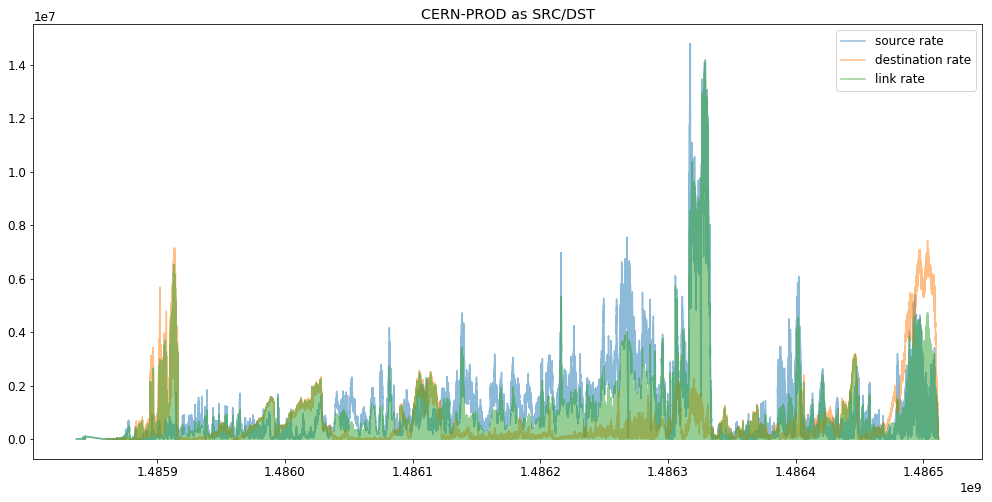

In [149]:
import matplotlib.pyplot as plt
plt.title('CERN-PROD as SRC/DST')
plt.plot(subset1.STARTED, subset1.RATE_SRC,'-', alpha=0.5, label='source rate')
plt.plot(subset2.STARTED, subset2.RATE_DST,'-', alpha=0.5, label='destination rate')
plt.plot(subset22.STARTED, subset22.RATE_NET,'-', alpha=0.5, label='link rate')
#plt.plot(subset2.STARTED, subset2.RATE_NET,'-', alpha=0.5, label='link rate')
fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.show()

In [150]:
subset3 = data.where(data.SRC_SITE == 'NDGF-T1').dropna()
subset4 = data.where(data.DST_SITE == 'NDGF-T1').dropna()
subset44 = subset3.append(subset4)

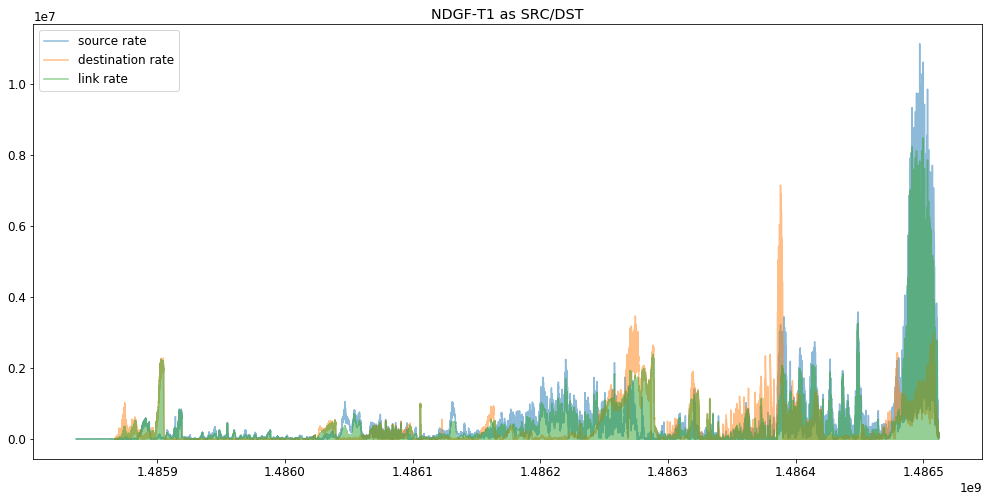

In [151]:
import matplotlib.pyplot as plt
plt.title('NDGF-T1 as SRC/DST')
plt.plot(subset3.STARTED, subset3.RATE_SRC,'-', alpha=0.5, label='source rate')
plt.plot(subset4.STARTED, subset4.RATE_DST,'-', alpha=0.5, label='destination rate')
plt.plot(subset44.STARTED, subset44.RATE_NET,'-', alpha=0.5, label='link rate')
fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.show()

In [153]:
subset5 = data.where(data.SRC_SITE == 'BNL-ATLAS').dropna()
subset6 = data.where(data.DST_SITE == 'BNL-ATLAS').dropna()
subset66 = subset5.append(subset6)

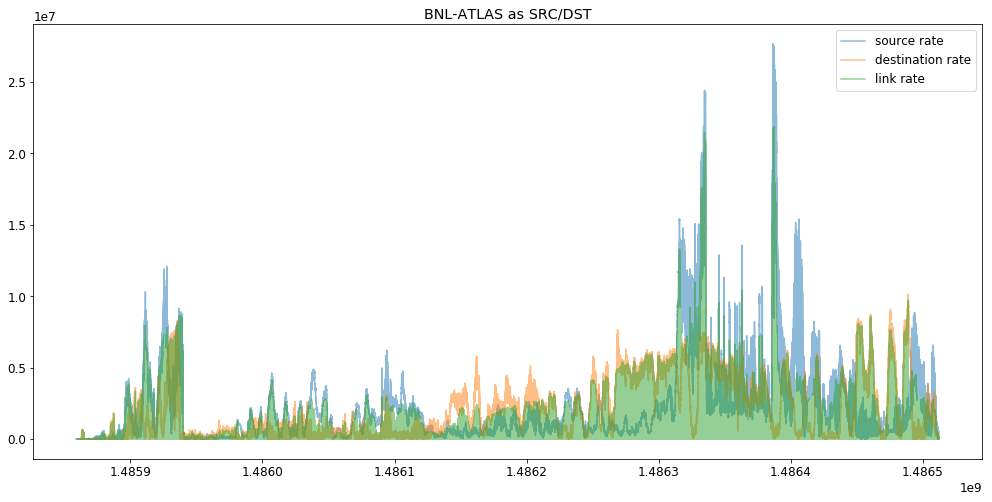

In [154]:
import matplotlib.pyplot as plt
plt.title('BNL-ATLAS as SRC/DST')
plt.plot(subset5.STARTED, subset5.RATE_SRC,'-', alpha=0.5, label='source rate')
plt.plot(subset6.STARTED, subset6.RATE_DST,'-', alpha=0.5, label='destination rate')
plt.plot(subset66.STARTED, subset66.RATE_NET,'-', alpha=0.5, label='link rate')
#plt.plot(subset5.STARTED, subset5.RATE_NET,'-', alpha=0.5, label='link rate')
#plt.plot(subset6.STARTED, subset6.RATE_NET,'-', alpha=0.5, label='link rate')
fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.show()

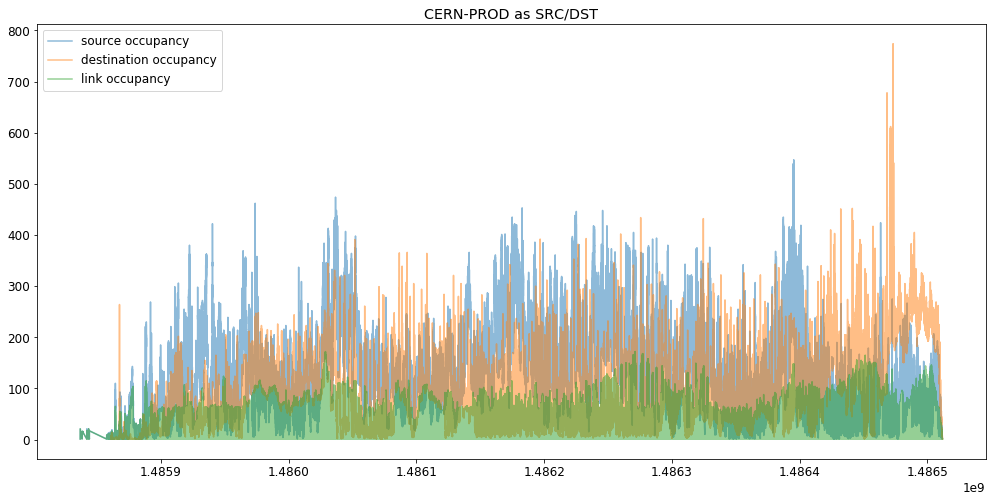

In [161]:
import matplotlib.pyplot as plt
plt.title('CERN-PROD as SRC/DST')
plt.plot(subset1.STARTED, subset1.OC_SRC,'-', alpha=0.5, label='source occupancy')
plt.plot(subset2.STARTED, subset2.OC_DST,'-', alpha=0.5, label='destination occupancy')
plt.plot(subset22.STARTED, subset22.OC_NET,'-', alpha=0.5, label='link occupancy')
#plt.plot(subset2.STARTED, subset2.RATE_NET,'-', alpha=0.5, label='link rate')
fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.show()

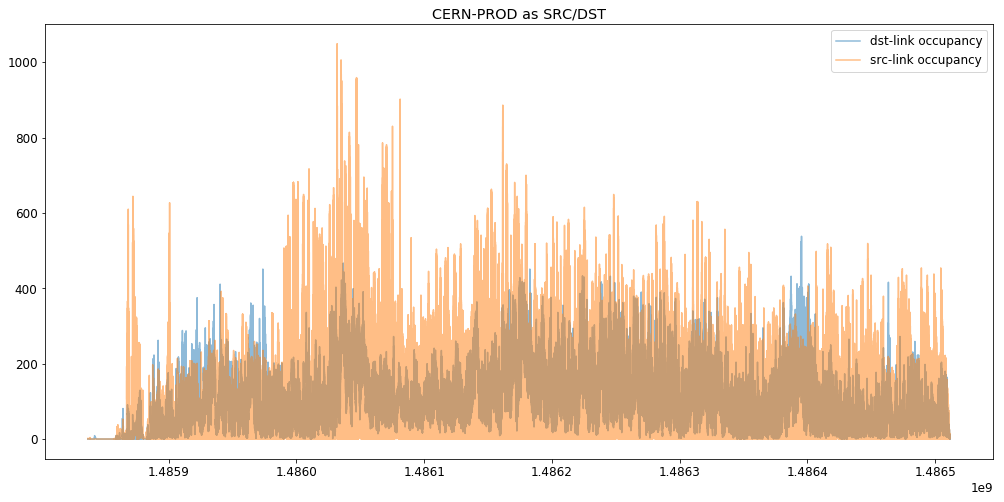

In [165]:
import matplotlib.pyplot as plt
plt.title('CERN-PROD as SRC/DST')
plt.plot(subset1.STARTED, subset1.OC_SRC - subset1.OC_NET,'-', alpha=0.5, label='dst-link occupancy')
plt.plot(subset1.STARTED, subset1.OC_DST - subset1.OC_NET,'-', alpha=0.5, label='src-link occupancy')
#plt.plot(subset2.STARTED, subset2.OC_DST,'-', alpha=0.5, label='destination occupancy')
#plt.plot(subset22.STARTED, subset22.OC_NET,'-', alpha=0.5, label='link occupancy')
#plt.plot(subset2.STARTED, subset2.RATE_NET,'-', alpha=0.5, label='link rate')
fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.show()